In [22]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, GlobalAveragePooling2D, Reshape, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
# Paths
train_dir = r'C:\Users\aishw\OneDrive\Desktop\fingerprint-based-blood-group-detection-main\fingerprint-based-blood-group-detection-main\dataset\splitted_dataset\aug'
val_dir = r'C:\Users\aishw\OneDrive\Desktop\fingerprint-based-blood-group-detection-main\fingerprint-based-blood-group-detection-main\dataset\splitted_dataset\val'
test_dir = r'C:\Users\aishw\OneDrive\Desktop\fingerprint-based-blood-group-detection-main\fingerprint-based-blood-group-detection-main\dataset\splitted_dataset\test'


In [24]:
# Image and Training Settings
img_height, img_width = 224, 224
batch_size = 32
epochs = 20


In [25]:
#Data Generators 
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical', shuffle=True)

val_generator = datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical', shuffle=False)

test_generator = datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical', shuffle=False)

num_classes = train_generator.num_classes

Found 22239 images belonging to 8 classes.
Found 1267 images belonging to 8 classes.
Found 1277 images belonging to 8 classes.


In [27]:
# Model Architecture
input_tensor = Input(shape=(img_height, img_width, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)


In [28]:
# Unfreeze Last 20 Layers for Fine-Tuning 
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((1, x.shape[-1]))(x)
x = GRU(256, return_sequences=False)(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_10 (Rescaling)      │ (None, 224, 224, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_5               │ (None, 224, 224, 3)       │               7 │ rescaling_10[0][0]         │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_11 (Rescaling)      │ (None, 224, 224, 3)       │               0 │ normalization_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_11[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 5,232,811 (19.96 MB)

 Trainable params: 2,534,200 (9.67 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [29]:
 #Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 557s 782ms/step - accuracy: 0.1728 - loss: 2.0575 - val_accuracy: 0.1823 - val_loss: 1.9947
Epoch 2/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 535s 770ms/step - accuracy: 0.2128 - loss: 1.9807 - val_accuracy: 0.1768 - val_loss: 1.9692
Epoch 3/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 535s 769ms/step - accuracy: 0.2188 - loss: 1.9414 - val_accuracy: 0.2005 - val_loss: 1.9510
Epoch 4/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 536s 771ms/step - accuracy: 0.2358 - loss: 1.9090 - val_accuracy: 0.2131 - val_loss: 1.9237
Epoch 5/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 535s 769ms/step - accuracy: 0.2635 - loss: 1.8710 - val_accuracy: 0.2644 - val_loss: 1.8610
Epoch 6/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 545s 785ms/step - accuracy: 0.2992 - loss: 1.8172 - val_accuracy: 0.3425 - val_loss: 1.7424
Epoch 7/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 546s 786ms/step - accuracy: 0.3276 - loss: 1.7507 - val_accuracy: 0.3765 - val_loss: 1.6185
Epoch 8/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 537s 772ms/step - accuracy: 0.3628 -

In [30]:
#  Evaluate on Test Set 
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 970ms/step - accuracy: 0.6601 - loss: 0.9399

✅ Test Accuracy: 64.06%


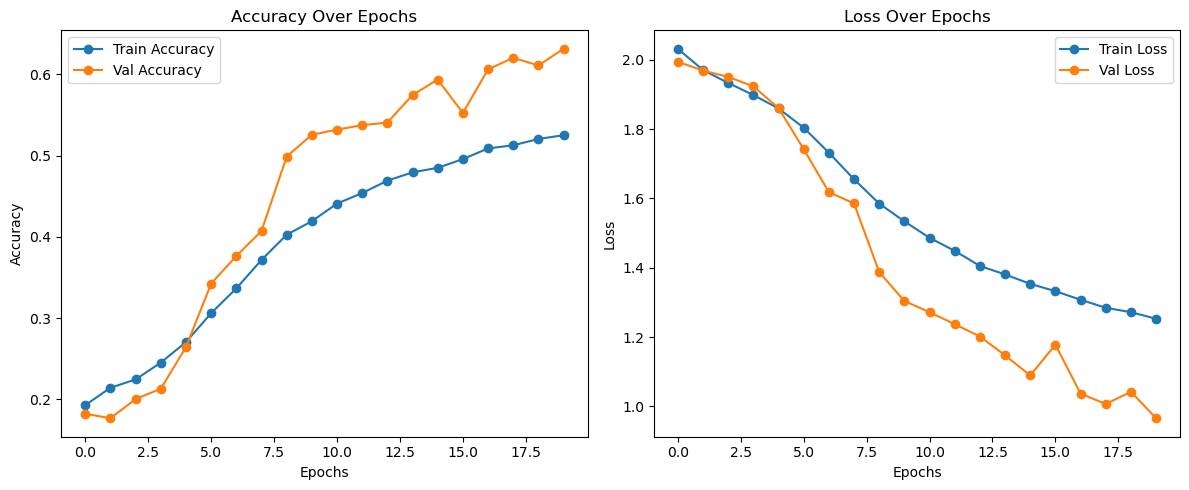

In [31]:
# Accuracy & Loss Plots 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
# Classification Report 
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 721ms/step

Classification Report:
              precision    recall  f1-score   support

          A+       0.96      0.47      0.63       139
          A-       0.50      0.92      0.65       201
         AB+       0.66      0.60      0.63       149
         AB-       0.64      0.73      0.68       153
          B+       0.62      0.55      0.59       165
          B-       0.86      0.73      0.79       149
          O+       0.59      0.65      0.62       178
          O-       0.85      0.36      0.51       143

    accuracy                           0.64      1277
   macro avg       0.71      0.63      0.64      1277
weighted avg       0.69      0.64      0.64      1277



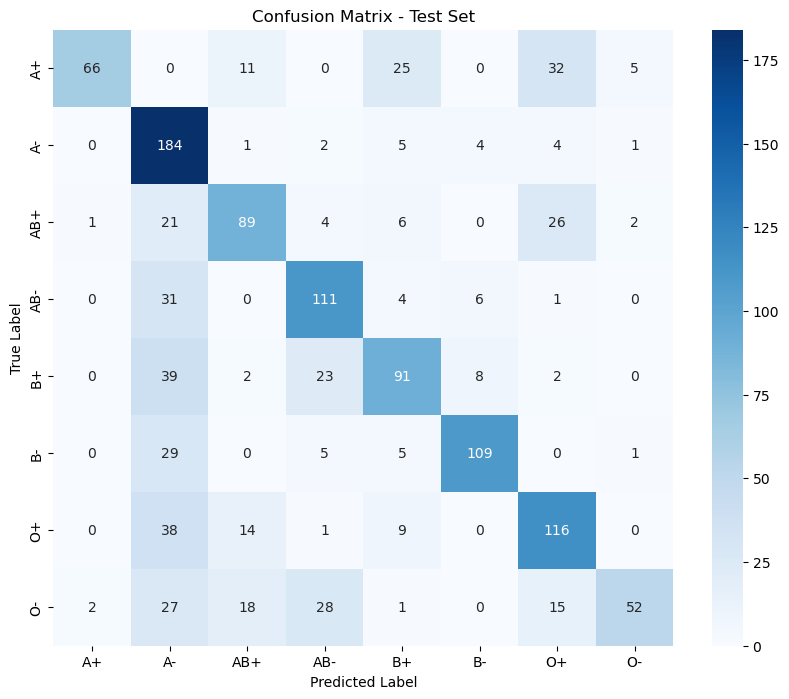

In [33]:
# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()